# Classical Pre-processing

In [1]:
import qiskit_machine_learning
qiskit_machine_learning.__version__

'0.7.2'

In [2]:
import numpy as np # type: ignore
import tensorflow as tf # type: ignore
from tensorflow.keras import datasets, layers, models   # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore
import time
import matplotlib.pyplot as plt # type: ignore
import warnings # type: ignore
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler

from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_algorithms.state_fidelities import ComputeUncompute

import ssl
ssl._create_default_https_context = ssl._create_unverified_context
 
import os
import certifi # type: ignore
os.environ['SSL_CERT_FILE'] = certifi.where()

In [ ]:
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

# Randomly select 2 classes
num_classes = 10
selected_classes = np.random.choice(range(num_classes), 2, replace=False)
print(f"Selected classes: {selected_classes}")

# Filter the train and test datasets to include only the selected classes
train_mask = np.isin(y_train, selected_classes)
test_mask = np.isin(y_test, selected_classes)

x_train = x_train[train_mask.squeeze()]
y_train = y_train[train_mask.squeeze()]
x_test = x_test[test_mask.squeeze()]
y_test = y_test[test_mask.squeeze()]

idx_train = 500
idx_test = 10
x_train = x_train[:idx_train]
x_test = x_test[:idx_test]
y_train = y_train[:idx_train]
y_test = y_test[:idx_test]

# Resize images to 8x8
im_size = 8
x_train = tf.image.resize(x_train, (im_size, im_size)).numpy()
x_test = tf.image.resize(x_test, (im_size, im_size)).numpy()

# Normalize the pixel values to [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# One-hot encode the labels for the selected classes
y_train = to_categorical(y_train, num_classes=num_classes)[:, selected_classes]
y_test = to_categorical(y_test, num_classes=num_classes)[:, selected_classes]

# Display the shapes of the processed datasets
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

Selected classes: [2 7]
(500, 8, 8, 3) (10, 8, 8, 3) (500, 2) (10, 2)


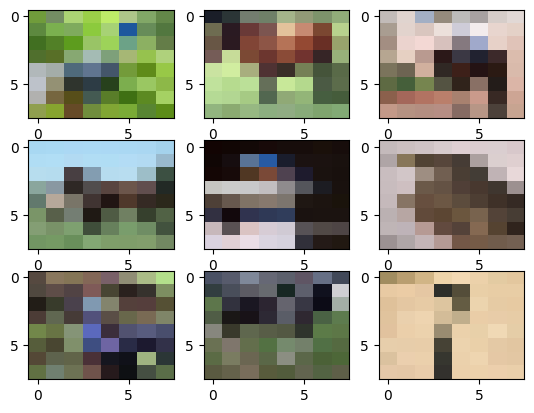

In [4]:
# visualize data by plotting images
fig, ax = plt.subplots(3, 3)
k = 0
for i in range(3):
    for j in range(3):
        ax[i][j].imshow(x_train[k], aspect='auto')
        k += 1
plt.show()

In [5]:
x_train_gray = tf.image.rgb_to_grayscale(x_train).numpy()
x_test_gray = tf.image.rgb_to_grayscale(x_test).numpy()

# Reshape the data to 1D vectors
x_train_rs = x_train_gray.reshape(x_train_gray.shape[0], -1)
x_test_rs = x_test_gray.reshape(x_test_gray.shape[0], -1)

from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Standardize the data to have a mean of 0 and variance of 1
scaler = StandardScaler()
x_train_s = scaler.fit_transform(x_train_rs)
x_test_s = scaler.transform(x_test_rs)

x_train_s.shape , x_test_s.shape

((500, 64), (10, 64))

In [6]:
# Apply PCA for feature reduction
from sklearn.decomposition import PCA
n_components = 8
pca = PCA(n_components=n_components)
x_train_pca = pca.fit_transform(x_train_s)
x_test_pca = pca.transform(x_test_s)

# Output the shape of the reduced data
print(f"Original shape: {x_train_s.shape}")
print(f"Reduced shape: {x_train_pca.shape}")

# Optional: Show explained variance to understand the amount of information retained
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Explained variance by {n_components} components: {explained_variance * 100:.2f}%")

Original shape: (500, 64)
Reduced shape: (500, 8)
Explained variance by 8 components: 68.35%


# Classical Support Vector Machine

In [7]:
import time
from sklearn import svm
from sklearn.model_selection import GridSearchCV

# param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}
# param_grid = {'C': [0.1, 1], 'gamma':[0.0001, 0.001], 'kernel': ['rbf', 'poly']}
%time
t0 = time.time()
model = svm.SVC(probability=True)
# model = GridSearchCV(svc,param_grid)
# print("Best Parameters:", model.best_params_)
# Train the SVM classifier
model.fit(x_train_pca, y_train.argmax(axis=1))
t1 = time.time()
print('The Model is trained with the given images')
print(f'Training set accuracy {model.score(x_train_pca, y_train.argmax(axis=1))}')


CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs
The Model is trained with the given images
Training set accuracy 0.788


In [8]:
# Make predictions on the validation set
y_pred = model.predict(x_test_pca)
t2 = time.time()
print(f"Time taken for training and testing:{t1-t0, t2-t1}")

Time taken for training and testing:(0.02457404136657715, 0.011674880981445312)


In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

# Evaluate accuracy, f1 score, precision, and confusion matrix

accuracy = accuracy_score(y_test.argmax(axis=1), y_pred)
f1 = f1_score(y_test.argmax(axis=1), y_pred, average='weighted')
precision = precision_score(y_test.argmax(axis=1), y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred)

print(f"Test Accuracy with SVM: {accuracy * 100:.2f}%")
print("F1 Score:", f1)
print("Precision:", precision)
print("Confusion Matrix:\n", conf_matrix)


Test Accuracy with SVM: 70.00%
F1 Score: 0.7098901098901099
Precision: 0.7333333333333334
Confusion Matrix:
 [[2 1]
 [2 5]]


# Classical SVM Insights: 
1. Training set accuracy 78.8%
2. Testing set accuracy with SVM: 70.00%
3. Train dataset size = 500, test size = 10
4. Randomly chosen 2 classes out of 10
5. Eache image is 8x8 pizel in size
6. Train time: 0.0246 s, Test time: 0.0117 s